# Installations, Imports, and Mounting Google Drive

In [ ]:
#installations
!pip install keras_preprocessing
!pip install tensorflow

# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords # Removing stopwords
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers.reshaping.flatten import Flatten
from keras.layers.pooling.max_pooling1d import MaxPool1D
from keras.models import Sequential, Model
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, multiply, Permute, Lambda
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras import backend as K
from keras.layers import Input, concatenate
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,classification_report,roc_curve
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph



#google colab drive mount code
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive


# Read in Data, and Explore the Data

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/WELFake_Dataset.csv') # reading data file

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
# Assuming your dataframe is named "df" and the class column is named "label"
class_counts = df['label'].value_counts()
print(class_counts)

1    37106
0    35028
Name: label, dtype: int64


so we can see an almost even split of class labels.

In [ ]:
df.columns = ["id","title","text","label"] #as can be seen above, the columns don't have great names. Update these names accordingly.
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      72134 non-null  int64 
 1   title   71576 non-null  object
 2   text    72095 non-null  object
 3   label   72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


# Preprocess the Data

### Drop id and title, as we are simply focusing on the content of the article, and the label associated with it:

In [ ]:
df.drop(labels=['id','title'], axis='columns', inplace=True)

In [ ]:
df['text'] #display some instances of the text

0        No comment is expected from Barack Obama Membe...
1           Did they post their votes for Hillary already?
2         Now, most of the demonstrators gathered last ...
3        A dozen politically active pastors came here f...
4        The RS-28 Sarmat missile, dubbed Satan 2, will...
                               ...                        
72129    WASHINGTON (Reuters) - Hackers believed to be ...
72130    You know, because in fantasyland Republicans n...
72131    Migrants Refuse To Leave Train At Refugee Camp...
72132    MEXICO CITY (Reuters) - Donald Trump’s combati...
72133    Goldman Sachs Endorses Hillary Clinton For Pre...
Name: text, Length: 72134, dtype: object

### We decide to drop data samples that are NA in the text field of each sample:

In [ ]:
df.dropna(subset = ["text"], inplace=True)

In [ ]:
class_counts = df['label'].value_counts()
print(class_counts) #check class counts again and compare to previous values to see which classes were affected by the removal of NA values

1    37067
0    35028
Name: label, dtype: int64


### Remove Stopwords

In [ ]:
def stopword_removal(row): #function to remove the stopwords, the function "remove_stopwords" is imported by gensim.parsing.preprocessing
    text = row['text']
    text = remove_stopwords(text)
    return text

df['text'] = df.apply(stopword_removal, axis=1)   #apply this stopword removal

### Apply Stemming

In [ ]:
nltk.download('punkt') #download punkt corpus, contains pretrained tokenizers used for tokenization of text.
nltk.download('wordnet') #download wordnet corpus, contains information about meaning of the words, the synonyms, antonyms, etc.
def preprocess_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming
    return " ".join(stemmed_tokens)  # Join the tokens back into a string

# Select the column containing the text data
text_column = 'text'  # Replace with your column name

# Apply text preprocessing to the selected column
df['text'] = df[text_column].apply(preprocess_text)

# Print the processed data
print(df[['text']])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                    text
0      no comment expect barack obama member # fyf911...
1                        did post vote hillari alreadi ?
2      now , demonstr gather night exercis constitut ...
3      a dozen polit activ pastor came privat dinner ...
4      the rs-28 sarmat missil , dub satan 2 , replac...
...                                                  ...
72129  washington ( reuter ) - hacker believ work rus...
72130  you know , fantasyland republican question cit...
72131  migrant refus to leav train at refuge camp in ...
72132  mexico citi ( reuter ) - donald trump ’ s comb...
72133  goldman sach endors hillari clinton for presid...

[72095 rows x 1 columns]


### More Data Exploration

Found 72095 texts.


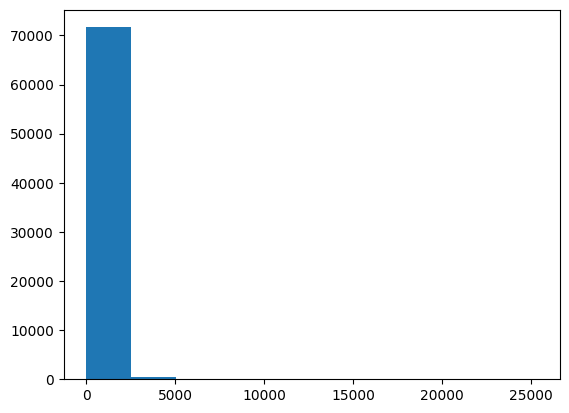

In [ ]:
# prepare text samples and their labels
texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

texts = texts.fillna("") #in case an NA value sneaked through the previous NA checker

# plot the distribution of article lengths in terms of word counts
text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

based on the above graph we can determine the following parameters. We increase the embedding dimension from baseline 64 to 100 in our case.

In [ ]:
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 1000
EMBEDDING_DIM = 100
TEST_SPLIT = 0.2

### Vectorize Text

In [ ]:
# vectorize the text samples into a 2D integer tensor

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) # tokenizing sentences into words

tokenizer.fit_on_texts(texts) # using fit_on_texts method assigning values to particular words

sequences = tokenizer.texts_to_sequences(texts) # texts_to_sequences method is used to give particular integer values to word


word_index = tokenizer.word_index # calculating word_index

num_words = min(MAX_NUM_WORDS, len(word_index)) + 1 #get number of words

data = pad_sequences(sequences,  # padding data to the same length for each samples
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index)) #print number of unique tokens
print('Shape of data tensor:', data.shape) #print shape of the data tensor
print('Shape of label tensor:', labels.shape) #print shape of the data tensor

Found 223042 unique tokens.
Shape of data tensor: (72095, 700)
Shape of label tensor: (72095,)


### Train Test Split

In [ ]:
# split the data into a training set and a validation set

x, x_test, y, y_test = train_test_split(data, #first split into training (80% of data) and testing (20%)
                                        labels,
                                        test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x, #split the 80% of training data into training(90% of the 80%) and validation (10% of the 80%),
                                                  y,
                                                  test_size=0.1)


In [ ]:
print(x_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

# Create our Models

## 1D-CNN

In [ ]:
OneD_CNN_Model = Sequential()
# part 1: word and sequence processing

OneD_CNN_Model.add(Embedding(input_dim =len(word_index),
                         output_dim = EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH))

# for defining convolutional layer, number of filters are set as 32 and kernal size is defined as 1 X 5.
OneD_CNN_Model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))

# maxpooling1d layer is used to take maximum values from representation.
OneD_CNN_Model.add(MaxPool1D(2))

# adding dropout 0.4
OneD_CNN_Model.add(Dropout(rate=0.4))

# creating second convolutional layer with kernal size 1 X 3, and number of filters will be 16. Where activation function will remain same as ReLU.
OneD_CNN_Model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))

# creating maxpooling layer with 2 neurons so that will compare with neighbour neuron.
OneD_CNN_Model.add(MaxPool1D(2, strides=2))

# adding one more convolutional layer with kernal size 1 X 3, and number of filters will be 8 and setting strides value as 2. Where activation function will be ReLU.
OneD_CNN_Model.add(Conv1D(filters=8, kernel_size=3, activation='relu', strides= 2))

# adding flatten layer
OneD_CNN_Model.add(Flatten())

# adding dense layer with 512 neurons
OneD_CNN_Model.add(Dense(units=512, activation='relu'))

# adding dropout layer of 0.25
OneD_CNN_Model.add(Dropout(rate=0.25))


# Adding attention matrix to the model
attention_probs = Dense(512, activation='softmax', name='attention_probs')(OneD_CNN_Model.layers[-1].output)
attention_mul = multiply([OneD_CNN_Model.layers[-1].output, attention_probs], name='attention_mul')
output_attention = Lambda(lambda x: K.sum(x, axis=1), name='output_attention')(attention_mul)

# output layer contains 1 value with a sigmoidal activation function because this is a binary classification problem.
OneD_CNN_Model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model, binary crossentropy because it is binary classification
OneD_CNN_Model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=0.001), #clipnorm reduces exploding gradient
              metrics=['accuracy'])

OneD_CNN_Model.summary()

#train the model for 15 epochs, 64 batch size
history_OneD_CNN_Model = OneD_CNN_Model.fit(x_train, y_train, batch_size=64, epochs=15, validation_data=(x_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          22304200  
                                                                 
 conv1d (Conv1D)             (None, 696, 32)           16032     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 348, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 348, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 346, 16)           1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 173, 16)          0         
 1D)                                                    

## GRU

In [ ]:
dropout = 0.5  #this was the optimal dropout value for both dropout layers upon testing
numberOfGRUNodes = 128 #determines number of nodes in the bidirectional GRU layer
GRU_Model = Sequential(
    [
        # Part 1: word and sequence processing
        layers.Embedding(input_dim =len(word_index), output_dim = EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=False),

        #add bidirectional GRU layer to look both before and after in the current sequence
        layers.Bidirectional(layers.GRU(numberOfGRUNodes, return_sequences=True)),

        #add global average pooling layer to reduce complexity
        layers.GlobalAveragePooling1D(),

        # Part 2: classification
        #add dense layer with 256 nodes to capture patterns extracted in the BiGRU layer.
        layers.Dense(256, activation='relu'),

        #add dropout layer to avoid overfitting
        layers.Dropout(dropout),

        #add dense layer with 256 nodes to capture patterns extracted in the BiGRU layer and previous dense layer.
        layers.Dense(128, activation='relu'),

        #add dropout layer to avoid overfitting
        layers.Dropout(dropout),

        # output layer contains 1 value with a sigmoidal activation function because this is a binary classification problem.
        layers.Dense(1, activation='sigmoid')
    ]
)
#next compile the GRU model, use binary crossentropy because it is binary classification
GRU_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#next train the GRU model
history_GRU_Model = GRU_Model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_val, y_val))



Epoch 1/30
406/406 [==============================] - 42s 88ms/step - loss: 0.6796 - accuracy: 0.5784 - val_loss: 0.6673 - val_accuracy: 0.6191
Epoch 2/30
406/406 [==============================] - 36s 88ms/step - loss: 0.5527 - accuracy: 0.7151 - val_loss: 0.3922 - val_accuracy: 0.8265
Epoch 3/30
406/406 [==============================] - 35s 85ms/step - loss: 0.2972 - accuracy: 0.8803 - val_loss: 0.2058 - val_accuracy: 0.9161
Epoch 4/30
406/406 [==============================] - 35s 85ms/step - loss: 0.1925 - accuracy: 0.9219 - val_loss: 0.1741 - val_accuracy: 0.9291
Epoch 5/30
406/406 [==============================] - 36s 88ms/step - loss: 0.1596 - accuracy: 0.9361 - val_loss: 0.1587 - val_accuracy: 0.9320
Epoch 6/30
406/406 [==============================] - 35s 85ms/step - loss: 0.1406 - accuracy: 0.9455 - val_loss: 0.1204 - val_accuracy: 0.9546
Epoch 7/30
406/406 [==============================] - 36s 88ms/step - loss: 0.1254 - accuracy: 0.9516 - val_loss: 0.1463 - val_accuracy:

## Ensemble

For the ensemble model, we are using the outputs of the previous two subnetworks (1D-CNN and GRU) for the inputs to this model.

In [ ]:
output_1D_CNN = OneD_CNN_Model.predict(x_test) #get predictions from 1D-CNN model based on the test set of data
output_GRU = GRU_Model.predict(x_test) #get predictions from GRU model based on the test set of data

# Outline the layers of the Meta-Model MLNN
#Next two lines are the inputs to the model, which are the outputs from the previous models
input_1D_CNN = Input(shape=(1,))
input_GRU = Input(shape=(1,))

#This concatenates the inputs together into a normal single layer.
concatenatedLayer = concatenate([input_1D_CNN, input_GRU])

#add dense layer with 256 nodes to capture patterns and mitigate biases between the 1D-CNN and GRU models.
hidden_layer1 = Dense(256, activation='relu')(concatenatedLayer)

#add dense layer with 32 nodes to capture patterns and mitigate biases between the 1D-CNN and GRU models and previous dense layer.
hidden_layer2 = Dense(32, activation='relu')(hidden_layer1)

#add dense layer with 16 nodes to capture patterns and mitigate biases between the 1D-CNN and GRU models and previous dense layer.
hidden_layer3 = Dense(16, activation='relu')(hidden_layer2)

# output layer contains 1 value with a sigmoidal activation function because this is a binary classification problem.
output_layer = Dense(1, activation='sigmoid')(hidden_layer3)

#Create the Meta-Model MLNN
meta_model = Model(inputs=[input_1D_CNN, input_GRU], outputs=output_layer)

# Compile the Meta-Model MLNN
meta_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Meta-Model MLNN with the outputs of Model 1 and Model 2
historyMetaModel = meta_model.fit([output_1D_CNN, output_GRU], y_test, batch_size=128, epochs=30, validation_split=0.2)

451/451 [==============================] - 9s 19ms/step
Epoch 1/30
91/91 [==============================] - 2s 6ms/step - loss: 0.4082 - accuracy: 0.9746 - val_loss: 0.1795 - val_accuracy: 0.9806
Epoch 2/30
91/91 [==============================] - 0s 5ms/step - loss: 0.0844 - accuracy: 0.9812 - val_loss: 0.0672 - val_accuracy: 0.9820
Epoch 3/30
91/91 [==============================] - 0s 4ms/step - loss: 0.0610 - accuracy: 0.9827 - val_loss: 0.0676 - val_accuracy: 0.9806
Epoch 4/30
91/91 [==============================] - 0s 5ms/step - loss: 0.0613 - accuracy: 0.9831 - val_loss: 0.0667 - val_accuracy: 0.9816
Epoch 5/30
91/91 [==============================] - 0s 5ms/step - loss: 0.0604 - accuracy: 0.9818 - val_loss: 0.0662 - val_accuracy: 0.9816
Epoch 6/30
91/91 [==============================] - 0s 5ms/step - loss: 0.0602 - accuracy: 0.9815 - val_loss: 0.0666 - val_accuracy: 0.9813
Epoch 7/30
91/91 [==============================] - 0s 5ms/step - loss: 0.0605 - accuracy: 0.9821 - val_

# Evaluate our Models

## Display ROC AUC, Per Sample Inference Time, Accuracies, and Classification Report

To do such a thing, we create our own evaluate model function that allows us to display what performance metrics we want to see.

In [ ]:
# define a function that allows us to evaluate models
def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    # training accuracy
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)


    #Next, time how long it takes to get all predictions from the X test set
    start_time = time.time() # Start timer
    y_predict_test = predict_fun(X_test)
    end_time = time.time() #Stop timer

    # Calculate inference time per sample by taking total time for inference divided by number of instances in the X test set
    inference_time = (end_time - start_time) / len(X_test)
    # Print inference time
    print("Per sample inference time =", inference_time)

    #testing accuracy
    test_acc = accuracy_score(y_test, y_predict_test)

    #create classification report
    cr = classification_report(y_test, y_predict_test,zero_division=1)

    #next we want to plot the ROC AUC curve.
    fpr, tpr, threshold = roc_curve(y_test, y_predict_test) #get the fpr, tpr, and theshold values as needed from the roc_curve function
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label= 'CNN')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('%s ROC Curve'% 'CNN',fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

    roc_auc_sc = roc_auc_score(y_test,y_predict_test) #get the roc auc score

    return train_acc, test_acc,cr,roc_auc_sc #return the metrics we want to display


Evaluate 1D-CNN Model:

451/451 [==============================] - 1s 2ms/step
Per sample inference time = 8.18012673279905e-05


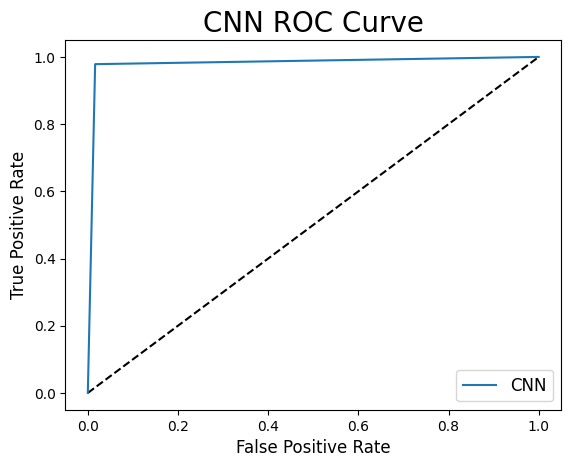

Training Accuracy: 99.91%
Testing Accuracy: 98.10%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      6901
           1       0.99      0.98      0.98      7518

    accuracy                           0.98     14419
   macro avg       0.98      0.98      0.98     14419
weighted avg       0.98      0.98      0.98     14419

AUC score 0.9811110919649962
Total time required for testing 11.82117223739624


In [ ]:
# evaluate model
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(OneD_CNN_Model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_test,
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total time required for testing",t.time()-start)

Evaluate GRU Model:

451/451 [==============================] - 9s 19ms/step
Per sample inference time = 0.0006159710250802638


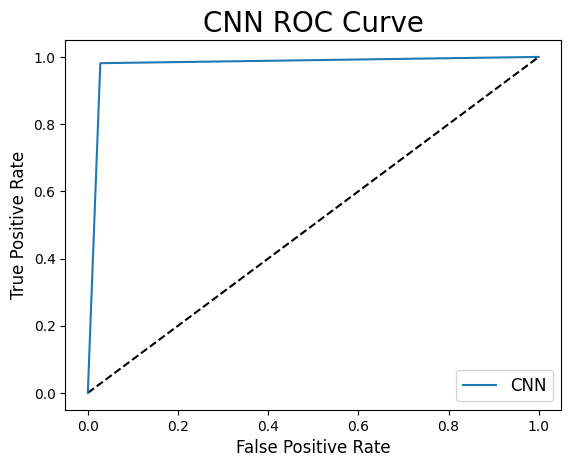

Training Accuracy: 99.58%
Testing Accuracy: 97.70%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      6901
           1       0.97      0.98      0.98      7518

    accuracy                           0.98     14419
   macro avg       0.98      0.98      0.98     14419
weighted avg       0.98      0.98      0.98     14419

AUC score 0.976850438915689
Total time required for testing 50.274255990982056


In [ ]:
# evaluate model
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(GRU_Model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_test,
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total time required for testing",t.time()-start)

The meta model cannot be evaluated using the same function as the previous two models due to their being a dual input to the function. Therefore, the evaluations are done manually as below:

In [ ]:
start_time = time.time()
meta_model_predictions = meta_model.predict([output_1D_CNN, output_GRU])
end_time = time.time()

inference_time = (end_time - start_time) / len(x_test)

# Print inference time
print("Total time required for testing",t.time()-start_time)
print("Per sample inference time =", inference_time)
threshold = 0.5
binary_predictions = np.where(meta_model_predictions >= threshold, 1, 0)
test_acc = accuracy_score(y_test, binary_predictions)
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

451/451 [==============================] - 1s 2ms/step
Total time required for testing 1.0629246234893799
Per sample inference time = 7.371071084576314e-05
Testing Accuracy: 98.13%


In [ ]:
for i in range(len(x_test)):
    print("Test Data:", x_test[i])
    print("True Label:", y_test[i])
    print("Predicted Label:", binary_predictions[i])
    print("index", i)
    print("---")


Test Data: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

KeyError: ignored

In [ ]:
roc_auc = roc_auc_score(y_test, binary_predictions)
print("AUC score",roc_auc)

AUC score 0.981651744840061


In [ ]:
threshold = 0.5
cr = classification_report(y_test, binary_predictions, zero_division=1)
print("Classification Report:\n",cr)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      6901
           1       0.99      0.97      0.98      7518

    accuracy                           0.98     14419
   macro avg       0.98      0.98      0.98     14419
weighted avg       0.98      0.98      0.98     14419



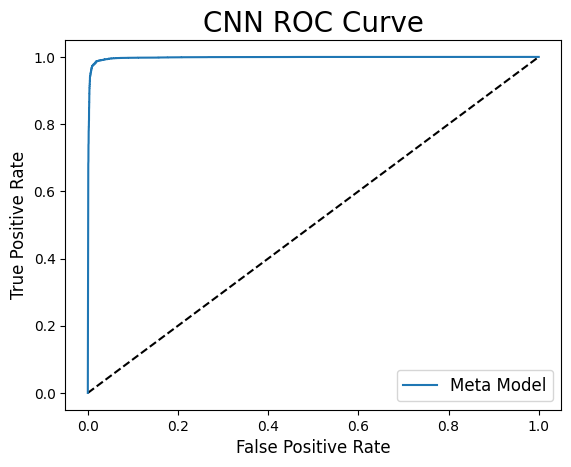

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,classification_report,roc_curve
fpr, tpr, threshold = roc_curve(y_test, meta_model_predictions)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label= 'Meta Model')
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('%s ROC Curve'% 'CNN',fontsize=20)
plt.legend(fontsize=12)
plt.show()

## Plot Training and Validation Accuracies + Losses

### 1D-CNN Model

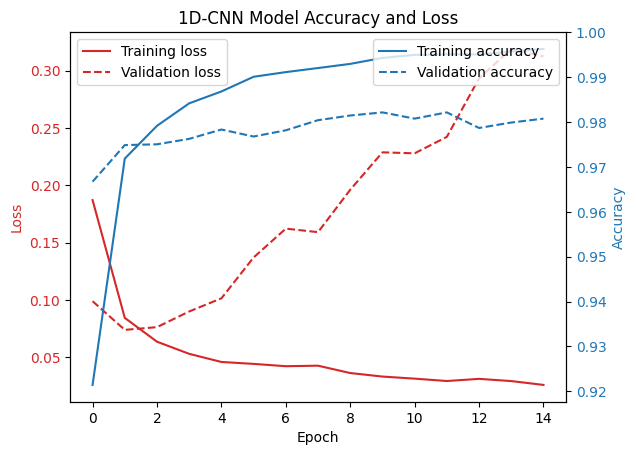

In [ ]:
# Plot training & validation accuracy values
fig, ax1 = plt.subplots()

color = 'tab:red' #plot loss in red
ax1.plot(history_OneD_CNN_Model.history['loss'], color=color) #plot training loss
ax1.plot(history_OneD_CNN_Model.history['val_loss'], color=color, linestyle='dashed') #plot validation loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue' #plot accuracy in blue
ax2.plot(history_OneD_CNN_Model.history['accuracy'], color=color) #plot training accuracy
ax2.plot(history_OneD_CNN_Model.history['val_accuracy'], color=color, linestyle='dashed') #plot validation accuracy
ax2.set_ylabel('Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add "Loss" label on the right side of the plot
ax1.legend(['Training loss', 'Validation loss'], loc='upper left')
ax2.legend(['Training accuracy', 'Validation accuracy'], loc='upper right')

plt.title('1D-CNN Model Accuracy and Loss')
plt.show()


### GRU Model

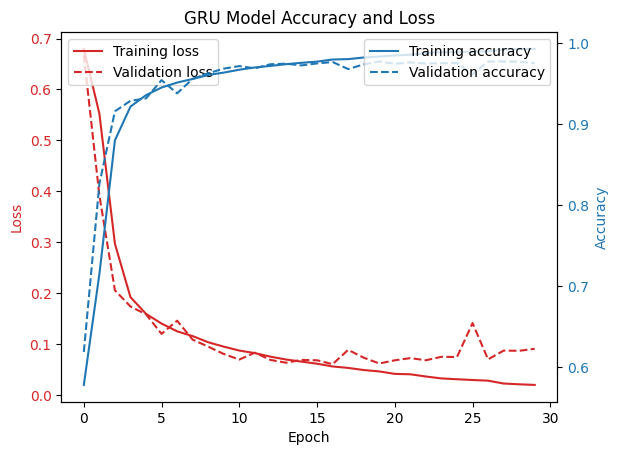

In [ ]:
# Plot training & validation accuracy values
fig, ax1 = plt.subplots()

color = 'tab:red' #plot loss in red
ax1.plot(history_GRU_Model.history['loss'], color=color) #plot training loss
ax1.plot(history_GRU_Model.history['val_loss'], color=color, linestyle='dashed') #plot validation loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue' #plot accuracy in blue
ax2.plot(history_GRU_Model.history['accuracy'], color=color) #plot training accuracy
ax2.plot(history_GRU_Model.history['val_accuracy'], color=color, linestyle='dashed') #plot validation accuracy
ax2.set_ylabel('Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add "Loss" label on the right side of the plot
ax1.legend(['Training loss', 'Validation loss'], loc='upper left')
ax2.legend(['Training accuracy', 'Validation accuracy'], loc='upper right')

plt.title('GRU Model Accuracy and Loss')
plt.show()


### Ensemble Meta Model

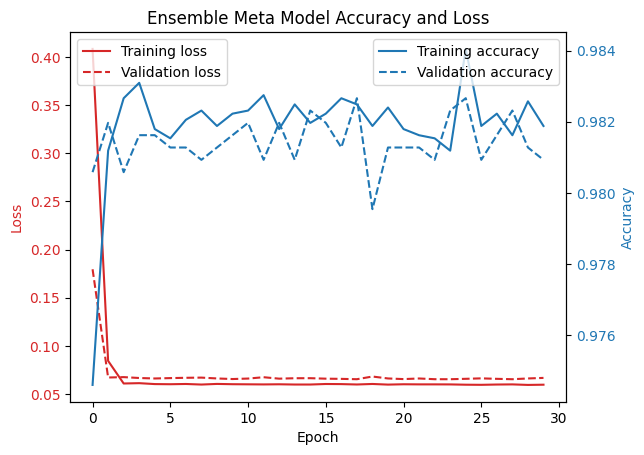

In [ ]:
# Plot training & validation accuracy values
fig, ax1 = plt.subplots()

color = 'tab:red' #plot loss in red
ax1.plot(historyMetaModel.history['loss'], color=color) #plot training loss
ax1.plot(historyMetaModel.history['val_loss'], color=color, linestyle='dashed') #plot validation loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue' #plot accuracy in blue
ax2.plot(historyMetaModel.history['accuracy'], color=color) #plot training accuracy
ax2.plot(historyMetaModel.history['val_accuracy'], color=color, linestyle='dashed') #plot validation accuracy
ax2.set_ylabel('Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add "Loss" label on the right side of the plot
ax1.legend(['Training loss', 'Validation loss'], loc='upper left')
ax2.legend(['Training accuracy', 'Validation accuracy'], loc='upper right')

plt.title('Ensemble Meta Model Accuracy and Loss')
plt.show()


## Get FLOPS for each sub-model:

In [ ]:
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops




### 1D-CNN

In [ ]:
flops = get_flops(OneD_CNN_Model)
print("Total FLOPs for 1D-CNN:", flops)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Total FLOPs for 1D-CNN: 24163313


### GRU

In [ ]:
flops = get_flops(GRU_Model)
print("Total FLOPs for GRU", flops)

Total FLOPs for GRU 197249
